In [2]:
import os
import copy

import torch
import tqdm
import torchvision

from typing import Literal

import abstract_gradient_training as agt
from abstract_gradient_training import AGTConfig
from abstract_gradient_training.bounded_models import IntervalBoundedModel

In [3]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split

def get_datasets(csv_path='cubic_with_noise.csv', test_size=0.2, balanced=False):
    """
    Load cubic dataset with noise from CSV and return train/test datasets as TensorDatasets.

    Args:
        csv_path (str): Path to the dataset CSV file.
        test_size (float): Fraction of data to use for testing.
        balanced (bool): Whether to balance the dataset based on the sign of the target.

    Returns:
        train_dataset, test_dataset (TensorDataset, TensorDataset)
    """

    # Load dataset
    df = pd.read_csv(csv_path)
    x = torch.tensor(df['x'].values, dtype=torch.float32).unsqueeze(1)
    y = torch.tensor(df['y'].values, dtype=torch.float32).unsqueeze(1)

    # Optional "balancing" — for example, balance data with y > 0 and y <= 0
    if balanced:
        y_binary = (y > 0).squeeze()
        idx_pos = torch.where(y_binary == 1)[0]
        idx_neg = torch.where(y_binary == 0)[0]
        n_samples = min(len(idx_pos), len(idx_neg))

        # Shuffle and sample
        idx_pos = idx_pos[torch.randperm(len(idx_pos))[:n_samples]]
        idx_neg = idx_neg[torch.randperm(len(idx_neg))[:n_samples]]
        idx = torch.cat([idx_pos, idx_neg])

        x = x[idx]
        y = y[idx]

    # Split into train/test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)

    # Wrap in TensorDataset
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

    return train_dataset, test_dataset


In [6]:
torch.manual_seed(1)
model = torch.nn.Sequential(
    torch.nn.Linear(1, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 1),
)

In [ ]:
# set up the pre-training configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
pretrain_batchsize = 1000000
pretrain_n_epochs = 25
pretrain_learning_rate = 1
dataset_pretrain, _ = get_datasets(balanced=True)
dl_pretrain = torch.utils.data.DataLoader(dataset_pretrain, batch_size=pretrain_batchsize, shuffle=True)
model = model.to(device)

In [8]:
criterion = torch.nn.MSELoss()
# criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=pretrain_learning_rate)
model = model.to(device)

In [ ]:
models_dir = ".models"
rerun = True
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# check if a pre-trained model exists
if os.path.exists(f"{models_dir}/x_3.ckpt") and not rerun:
    model.load_state_dict(torch.load(f"{models_dir}/x_3.ckpt"))
else:  # pre-train the model
    progress_bar = tqdm.trange(pretrain_n_epochs, desc="Epoch", )
    for epoch in progress_bar:
        for i, (x, u) in enumerate(dl_pretrain):
            # Forward pass
            u, x = u.to(device), x.to(device)
            output = model(x)
            loss = criterion(output.squeeze().float(), u.squeeze().float())
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            print(loss)
            if i % 100 == 0:
                progress_bar.set_postfix(loss=loss.item())
    # save the model
    with open(f"{models_dir}/x_3.ckpt", "wb") as file:
        torch.save(model.state_dict(), file)

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch:   4%|▍         | 1/25 [00:11<04:40, 11.68s/it, loss=133]

tensor(133.4118, grad_fn=<MseLossBackward0>)


Epoch:   8%|▊         | 2/25 [00:23<04:25, 11.56s/it, loss=198]

tensor(197.5655, grad_fn=<MseLossBackward0>)


Epoch:  12%|█▏        | 3/25 [00:34<04:08, 11.32s/it, loss=974]

tensor(973.7467, grad_fn=<MseLossBackward0>)


Epoch:  16%|█▌        | 4/25 [00:44<03:46, 10.81s/it, loss=202]

tensor(202.4293, grad_fn=<MseLossBackward0>)


Epoch:  20%|██        | 5/25 [00:54<03:33, 10.67s/it, loss=181]

tensor(180.6172, grad_fn=<MseLossBackward0>)


Epoch:  24%|██▍       | 6/25 [01:04<03:18, 10.47s/it, loss=102]

tensor(102.4689, grad_fn=<MseLossBackward0>)


Epoch:  28%|██▊       | 7/25 [01:14<03:04, 10.27s/it, loss=89.3]

tensor(89.3124, grad_fn=<MseLossBackward0>)


Epoch:  32%|███▏      | 8/25 [01:23<02:49,  9.98s/it, loss=79.4]

tensor(79.3844, grad_fn=<MseLossBackward0>)


Epoch:  36%|███▌      | 9/25 [01:33<02:37,  9.84s/it, loss=86.9]

tensor(86.9046, grad_fn=<MseLossBackward0>)


Epoch:  40%|████      | 10/25 [01:42<02:25,  9.72s/it, loss=110]

tensor(110.0459, grad_fn=<MseLossBackward0>)


Epoch:  44%|████▍     | 11/25 [01:54<02:23, 10.28s/it, loss=120]

tensor(119.6943, grad_fn=<MseLossBackward0>)


Epoch:  48%|████▊     | 12/25 [02:09<02:30, 11.60s/it, loss=106]

tensor(106.0012, grad_fn=<MseLossBackward0>)


Epoch:  52%|█████▏    | 13/25 [02:20<02:17, 11.50s/it, loss=74.7]

tensor(74.7218, grad_fn=<MseLossBackward0>)


Epoch:  56%|█████▌    | 14/25 [02:31<02:05, 11.40s/it, loss=46]  

tensor(45.9627, grad_fn=<MseLossBackward0>)


Epoch:  60%|██████    | 15/25 [02:42<01:52, 11.24s/it, loss=41.8]

tensor(41.8118, grad_fn=<MseLossBackward0>)


Epoch:  64%|██████▍   | 16/25 [02:55<01:46, 11.79s/it, loss=65.7]

tensor(65.6716, grad_fn=<MseLossBackward0>)


Epoch:  68%|██████▊   | 17/25 [03:05<01:30, 11.37s/it, loss=65.1]

tensor(65.0560, grad_fn=<MseLossBackward0>)


Epoch:  72%|███████▏  | 18/25 [03:16<01:17, 11.01s/it, loss=46]  

tensor(45.9705, grad_fn=<MseLossBackward0>)


Epoch:  76%|███████▌  | 19/25 [03:26<01:05, 10.88s/it, loss=40.8]

tensor(40.8173, grad_fn=<MseLossBackward0>)


Epoch:  80%|████████  | 20/25 [03:38<00:55, 11.15s/it, loss=43.7]

tensor(43.7136, grad_fn=<MseLossBackward0>)


Epoch:  84%|████████▍ | 21/25 [03:48<00:43, 10.84s/it, loss=40.3]

tensor(40.3213, grad_fn=<MseLossBackward0>)


Epoch:  88%|████████▊ | 22/25 [03:58<00:31, 10.65s/it, loss=32]  

tensor(31.9562, grad_fn=<MseLossBackward0>)


Epoch:  92%|█████████▏| 23/25 [04:08<00:21, 10.51s/it, loss=30]

tensor(30.0088, grad_fn=<MseLossBackward0>)


Epoch:  96%|█████████▌| 24/25 [04:19<00:10, 10.58s/it, loss=34.8]

tensor(34.8340, grad_fn=<MseLossBackward0>)


Epoch: 100%|██████████| 25/25 [04:30<00:00, 10.81s/it, loss=35]  

tensor(34.9698, grad_fn=<MseLossBackward0>)


In [8]:
# evaluate the pre-trained model
_, dataset_test_all = get_datasets()
x, u = dataset_test_all.tensors
u, x = u.to(device), x.to(device)
output = model(x)
out = torch.cat((x, x * x * x, u, output), 1)

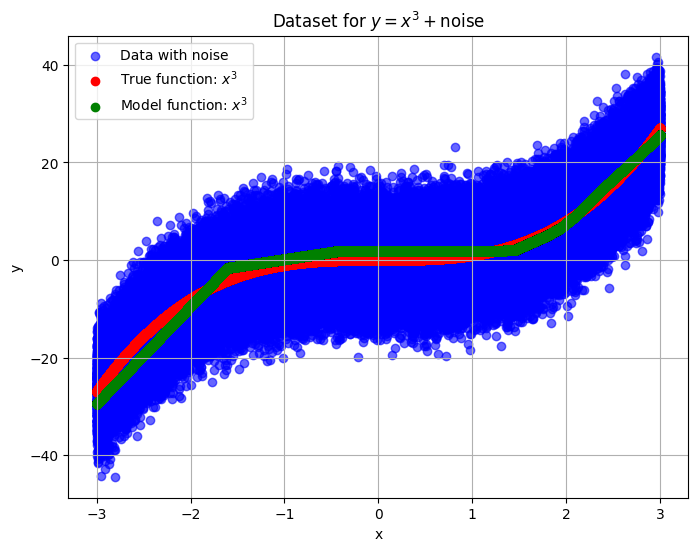

In [9]:
import matplotlib.pyplot as plt

# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(x.tolist(), u.tolist(), color='blue', alpha=0.6, label='Data with noise')
plt.scatter(x.tolist(), (x * x * x).tolist(), color='red', label='True function: $x^3$')
plt.scatter(x.tolist(), output.tolist(), color='green', label='Model function: $x^3$')
plt.title('Dataset for $y = x^3 + \\text{noise}$')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
# plt.savefig("tmp.png")

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# set up the AGT configuration
batchsize = 1000000
nominal_config = AGTConfig(
    fragsize=2000,
    learning_rate=1,
    n_epochs=5,
    device="cuda:0",
    # device="cuda:1",
    # device="cpu",
    l2_reg=0.01,
    k_private=1,
    loss="mse",
    log_level="INFO",
    lr_decay=2.0,
    clip_gamma=1.0,
    lr_min=0.001,
    optimizer="SGDM", # we'll use SGD with momentum
    optimizer_kwargs={"momentum": 0.9, "nesterov": True},
)

In [7]:
# get dataloaders
dataset_train, dataset_test = get_datasets(balanced=True) 
torch.manual_seed(0)

dl_train = torch.utils.data.DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
dl_test = torch.utils.data.DataLoader(dataset_test, batch_size=batchsize, shuffle=False)

In [15]:
torch.manual_seed(1)
model = torch.nn.Sequential(
    torch.nn.Linear(1, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 1),
)
bounded_model = IntervalBoundedModel(model, trainable=True)

In [16]:
agt.privacy_certified_training(bounded_model, nominal_config, dl_train, dl_test)

[AGT] [INFO    ] [14:58:15] =================== Starting Privacy Certified Training ===================
[AGT] [INFO    ] [14:58:16] Starting epoch 1
[AGT] [INFO    ] [14:58:28] Batch 1. Loss (mse): 132.487 <= 132.487 <= 132.487
[AGT] [INFO    ] [14:59:42] Dataloader has only one batch per epoch, effective batchsize may be smaller than expected.
[AGT] [INFO    ] [14:59:42] Starting epoch 2
[AGT] [INFO    ] [14:59:54] Batch 2. Loss (mse): 59.846 <= 59.848 <= 59.850
[AGT] [INFO    ] [15:01:11] Starting epoch 3
[AGT] [INFO    ] [15:01:23] Batch 3. Loss (mse): 48.734 <= 48.740 <= 48.745
[AGT] [INFO    ] [15:02:38] Starting epoch 4
[AGT] [INFO    ] [15:02:50] Batch 4. Loss (mse): 47.030 <= 47.042 <= 47.054
[AGT] [INFO    ] [15:04:06] Starting epoch 5
[AGT] [INFO    ] [15:04:17] Batch 5. Loss (mse): 46.987 <= 47.011 <= 47.035
[AGT] [INFO    ] [15:05:38] Final Eval. Loss (mse): 47.294 <= 47.338 <= 47.382
[AGT] [INFO    ] [15:05:38] =================== Finished Privacy Certified Training ======

IntervalBoundedModel(
	self.modules=[
		Linear(in_features=1, out_features=32, bias=True)
		ReLU()
		Linear(in_features=32, out_features=1, bias=True)
	],
	self.interval_matmul='rump',
	self.trainable=True,
)

In [17]:
# evaluate the fine-tuned model
_, dataset_test_all = get_datasets()
accuracy = agt.test_metrics.test_mse(bounded_model, *dataset_test_all.tensors)
print(f"Fine-tuned model accuracy + certified bounds (all classes): {accuracy[0]:.2f} <= {accuracy[1]:.2f} <= {accuracy[2]:.2f}")

Fine-tuned model accuracy + certified bounds (all classes): 47.71 <= 47.67 <= 47.63


In [9]:
import torch.nn.functional as F
from abstract_gradient_training.bounded_models import BoundedModel
def noisy_test_mse(
    model: torch.nn.Sequential | BoundedModel,
    batch: torch.Tensor,
    labels: torch.Tensor,
    noise_level: float | torch.Tensor = 0.0,
    noise_type: str = "laplace",
) -> float:
    """
    Given a pytorch (or bounded) model, calculate the prediction accuracy on a batch of the test set when adding the
    specified noise to the predictions.
    NOTE: For now, this function only supports binary classification via the noise + threshold dp mechanism. This
          should be extended to support multi-class problems via the noisy-argmax mechanism in the future.

    Args:
        model (torch.nn.Sequential | BoundedModel): The model to evaluate.
        batch (torch.Tensor): Input batch of data (shape [batchsize, ...]).
        labels (torch.Tensor): Targets for the input batch (shape [batchsize, ]).
        noise_level (float | torch.Tensor, optional): Noise level for privacy-preserving predictions using the laplace
            mechanism. Can either be a float or a torch.Tensor of shape (batchsize, ).
        noise_type (str, optional): Type of noise to add to the predictions, one of ["laplace", "cauchy"].

    Returns:
        float: The noisy accuracy of the model on the test set.
    """
    # get the test batch and send it to the correct device
    if isinstance(model, BoundedModel):
        device = torch.device(model.device) if model.device != -1 else torch.device("cpu")
    else:
        device = torch.device(next(model.parameters()).device)
    batch = batch.to(device)
    
    # validate the labels
    if labels.dim() > 1:
        labels = labels.squeeze()
        
    labels = labels.to(device).type(torch.float64)
    assert labels.dim() == 1, "Labels must be of shape (batchsize, )"

    if noise_type in ["none"]:
        # nominal, lower and upper bounds for the forward pass
        y_n = model.forward(batch).squeeze()
        return F.mse_loss(y_n, labels.squeeze()).item()

    # validate the noise parameters and set up the distribution
    assert noise_type in ["laplace", "cauchy"], f"Noise type must be one of ['laplace', 'cauchy'], got {noise_type}"
    noise_level += 1e-7  # can't set distributions scale to zero
    noise_level = torch.tensor(noise_level) if isinstance(noise_level, float) else noise_level
    noise_level = noise_level.to(device).type(batch.dtype)  # type: ignore
    noise_level = noise_level.expand(labels.size())
    if noise_type == "laplace":
        noise_distribution = torch.distributions.Laplace(0, noise_level)
    else:
        noise_distribution = torch.distributions.Cauchy(0, noise_level)

    # nominal, lower and upper bounds for the forward pass
    y_n = model.forward(batch).squeeze()

    # transform 2-logit models to a single output
    if y_n.shape[-1] == 2:
        y_n = y_n[:, 1] - y_n[:, 0]
    if y_n.dim() > 1:
        raise NotImplementedError("Noisy accuracy is not supported for multi-class classification.")

    # apply noise + threshold dp mechanisim
    noise = noise_distribution.sample().to(y_n.device).squeeze()
    assert noise.shape == y_n.shape
    y_n = y_n + noise
    accuracy = F.mse_loss(y_n, labels.squeeze()).item()
    return accuracy

In [20]:
# make privacy-safe predictions using the global sensitivity
epsilon = 1.0
_, dataset_test_all = get_datasets()
loss = noisy_test_mse(
    bounded_model, *dataset_test_all.tensors, noise_level=1 / epsilon, noise_type="laplace"
)
print(f"Loss using global sensitivity: {loss:.2f}")

Loss using global sensitivity: 46.49


In [4]:
import importlib
import privacy_utils_regression
importlib.reload(privacy_utils_regression)
privacy_bounded_models = {}
privacy_bounded_models[1] = bounded_model

# make privacy-safe predictions using the smooth sensitivity bounds from AGT
noise_level = privacy_utils_regression.get_calibrated_noise_level(
    dataset_test_all.tensors[0], privacy_bounded_models, min_bound=-1, max_bound=1, epsilon=epsilon, noise_type="cauchy" 
)
print(noise_level)
accuracy = noisy_test_mse(
    bounded_model, *dataset_test_all.tensors, noise_level=noise_level, noise_type="cauchy"
)
print(f"Accuracy using AGT smooth sensitivity bounds: {accuracy:.2f}")

NameError: name 'bounded_model' is not defined

In [4]:
# set up the AGT configuration
batchsize = 1000000
nominal_config = AGTConfig(
    fragsize=2000,
    learning_rate=1,
    n_epochs=10,
    device="cuda:0",
    l2_reg=0.01,
    k_private=1,
    loss="mse",
    log_level="INFO",
    lr_decay=2.0,
    clip_gamma=1.0,
    lr_min=0.001,
    optimizer="SGDM", # we'll use SGD with momentum
    optimizer_kwargs={"momentum": 0.9, "nesterov": True},
)

In [ ]:
# to use privacy-safe certificates, we need to run AGT for a range of k_private values

# we'll just pick a reasonable range of k_private values. adding more values will increase the runtime
# but also result in tighter privacy results. even a few values are sufficient to demonstrate tighter privacy

k_private_values = [1, 2, 5, 10, 20, 50, 100] 
privacy_bounded_models = {}
config = copy.deepcopy(nominal_config)
config.log_level = "WARNING"

for k_private in tqdm.tqdm(k_private_values):
    # update config
    config.k_private = k_private
    # form bounded model
    torch.manual_seed(1)
    model = torch.nn.Sequential(
        torch.nn.Linear(1, 32),
        torch.nn.ReLU(),
        torch.nn.Linear(32, 1),
    )
    bounded_model = IntervalBoundedModel(model, trainable=True)
    dl_train = torch.utils.data.DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
    # run AGT
    agt.privacy_certified_training(bounded_model, nominal_config, dl_train, dl_test)
    privacy_bounded_models[k_private] = bounded_model

  0%|          | 0/7 [00:00<?, ?it/s][AGT] [INFO    ] [15:22:36] =================== Starting Privacy Certified Training ===================
[AGT] [INFO    ] [15:22:36] Starting epoch 1
[AGT] [INFO    ] [15:22:49] Batch 1. Loss (mse): 132.487 <= 132.487 <= 132.487
[AGT] [INFO    ] [15:24:05] Dataloader has only one batch per epoch, effective batchsize may be smaller than expected.
[AGT] [INFO    ] [15:24:05] Starting epoch 2
[AGT] [INFO    ] [15:24:18] Batch 2. Loss (mse): 59.846 <= 59.848 <= 59.850
[AGT] [INFO    ] [15:25:51] Starting epoch 3
[AGT] [INFO    ] [15:26:06] Batch 3. Loss (mse): 48.734 <= 48.740 <= 48.745
[AGT] [INFO    ] [15:27:22] Starting epoch 4
[AGT] [INFO    ] [15:27:34] Batch 4. Loss (mse): 47.030 <= 47.042 <= 47.054
[AGT] [INFO    ] [15:28:48] Starting epoch 5
[AGT] [INFO    ] [15:29:00] Batch 5. Loss (mse): 46.987 <= 47.011 <= 47.035
[AGT] [INFO    ] [15:30:15] Starting epoch 6
[AGT] [INFO    ] [15:30:26] Batch 6. Loss (mse): 47.294 <= 47.338 <= 47.382
[AGT] [INFO

In [ ]:
for k in k_private_values:
    privacy_bounded_models[k].save_params(f"cubic_k{k}.model")

KeyError: 1

In [6]:
privacy_bounded_models = {}
k_private_values = [1, 2, 5, 10, 20, 50, 100] 
for k in k_private_values:
    model = torch.nn.Sequential(
        torch.nn.Linear(1, 32),
        torch.nn.ReLU(),
        torch.nn.Linear(32, 1),
    )
    bounded_model = IntervalBoundedModel(model, trainable=True)
    bounded_model.load_params(f"cubic_models/cubic_k{k}.model")
    privacy_bounded_models[k] = bounded_model
# evaluate the fine-tuned model
_, dataset_test_all = get_datasets()
accuracy = agt.test_metrics.test_mse(bounded_model, *dataset_test_all.tensors)
print(f"Fine-tuned model accuracy + certified bounds (all classes): {accuracy[0]:.2f} <= {accuracy[1]:.2f} <= {accuracy[2]:.2f}")

Fine-tuned model accuracy + certified bounds (all classes): 51.27 <= 50.81 <= 50.34


In [7]:
import importlib
import privacy_utils_regression
importlib.reload(privacy_utils_regression)

epsilon = 1.0
# make privacy-safe predictions using the smooth sensitivity bounds from AGT
noise_level = privacy_utils_regression.get_calibrated_noise_level(
    dataset_test_all.tensors[0], privacy_bounded_models, min_bound=-27, max_bound=27, epsilon=epsilon, noise_type="cauchy" 
)

accuracy = noisy_test_mse(
    bounded_model, *dataset_test_all.tensors, noise_level=noise_level, noise_type="cauchy"
)
print(accuracy / len(dataset_test_all))
print(f"Accuracy using AGT smooth sensitivity bounds: {accuracy:.2f}")

ave = 0
num = 10000
for i in range(num):
    ave += noisy_test_mse(
        bounded_model, *dataset_test_all.tensors, noise_level=noise_level, noise_type="cauchy"
    )
print(f"Average MSE is {ave / (num * len(dataset_test_all))}")

0.1968840110718544
Accuracy using AGT smooth sensitivity bounds: 39376.80


KeyboardInterrupt: 

In [11]:
ave = 0
num = 10000
for i in range(num):
    ave += noisy_test_mse(
        bounded_model, *dataset_test_all.tensors, noise_level=6 * 54, noise_type="cauchy"
    )
print(f"Average MSE global sensitivity is {ave / (num * len(dataset_test_all))}")

Average MSE global sensitivity is 1970750.880673056


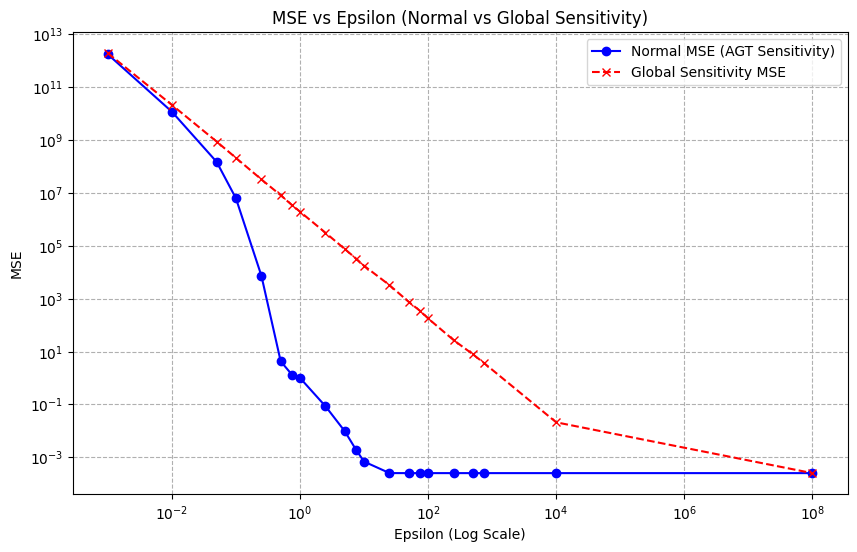

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the specific epsilon values
epsilon_values = [0.001, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 2.5, 5, 7.5, 10, 25, 50, 75, 100, 250, 500, 750, 10000, 100000000]

# Store results for both normal MSE and global sensitivity-based MSE
normal_mse_values = []
global_sensitivity_mse_values = []
no_privacy_mse_values = []

# Loop over epsilon values and calculate the MSE for each
for epsilon in epsilon_values:
    # Calculate the noise level using AGT smooth sensitivity bounds
    noise_level = privacy_utils_regression.get_calibrated_noise_level(
        dataset_test_all.tensors[0], privacy_bounded_models, min_bound=-27, max_bound=27, epsilon=epsilon, noise_type="cauchy"
    )
    
    ave = 0
    num = 1000
    for i in range(num):
        ave += noisy_test_mse(
            bounded_model, *dataset_test_all.tensors, noise_level=noise_level, noise_type="cauchy"
        )
    normal_mse = ave / (num * len(dataset_test_all))
    # print(f"Average MSE is {ave / (num * len(dataset_test_all))}")
    
    # Store normal MSE
    normal_mse_values.append(normal_mse)
    

    ave = 0
    num = 1000
    for i in range(num):
        ave += noisy_test_mse(
            bounded_model, *dataset_test_all.tensors, noise_level=6 * 54/epsilon, noise_type="cauchy"
        )
    
    global_mse = ave / (num * len(dataset_test_all))
    # Store global sensitivity MSE
    global_sensitivity_mse_values.append(global_mse)

    no_privacy_mse = noisy_test_mse(
            bounded_model, *dataset_test_all.tensors, noise_level=0, noise_type="none"
        ) / len(dataset_test_all)
    # Store global sensitivity MSE
    no_privacy_mse_values.append(no_privacy_mse)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot both MSE curves
plt.plot(epsilon_values, normal_mse_values, label="Normal MSE (AGT Sensitivity)", color="blue", marker='o')
plt.plot(epsilon_values, global_sensitivity_mse_values, label="Global Sensitivity MSE", color="red", linestyle="--", marker='x')
plt.plot(epsilon_values, no_privacy_mse_values, label="No Privacy MSE", color="green")

# Set x-axis to logarithmic scale
plt.xscale('log')

# Set y-axis to logarithmic scale
plt.yscale('log')

# Add labels and title
plt.xlabel('Epsilon (Log Scale)')
plt.ylabel('MSE')
plt.title('MSE vs Epsilon (Normal vs Global Sensitivity)')
plt.legend()

# Show the plot
plt.grid(True, which="both", ls="--")  # Add grid for both major and minor ticks
plt.show()
